In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 실습용 전자상거래 데이터 생성
np.random.seed(42)

# 고객 데이터 생성
customers = pd.DataFrame({
    'customer_id': range(1, 1001),
    'first_purchase_date': pd.date_range('2022-01-01', periods=1000, freq='D'),
    'acquisition_channel': np.random.choice(['organic', 'paid_search', 'social', 'email'], 1000, 
                                          p=[0.4, 0.3, 0.2, 0.1])
})

# 거래 데이터 생성 (더 현실적인 패턴)
transactions = []
for customer_id in range(1, 1001):
    first_date = customers[customers['customer_id'] == customer_id]['first_purchase_date'].iloc[0]
    
    # 고객별로 다른 구매 패턴 시뮬레이션
    purchase_frequency = np.random.exponential(30)  # 평균 30일마다 구매
    num_purchases = np.random.poisson(3) + 1  # 평균 3회 구매
    
    for i in range(num_purchases):
        purchase_date = first_date + timedelta(days=int(i * purchase_frequency))
        if purchase_date <= datetime(2024, 12, 31):
            transactions.append({
                'customer_id': customer_id,
                'purchase_date': purchase_date,
                'order_value': np.random.lognormal(4, 0.8),  # 로그정규분포로 현실적인 주문금액
                'order_id': len(transactions) + 1
            })

df = pd.DataFrame(transactions)
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

print("데이터셋 개요")
print(f"총 고객 수: {len(customers):,}명")
print(f"총 거래 수: {len(df):,}건")
print(f"기간: {df['purchase_date'].min().date()} ~ {df['purchase_date'].max().date()}")

데이터셋 개요
총 고객 수: 1,000명
총 거래 수: 3,871건
기간: 2022-01-01 ~ 2024-12-28


## RFM 분석

# 고객을 3가지 측면에서 바라보는 프리즘

# Recency: 얼마나 최근에 구매하는가? (최근성)
# Frequency: 얼마나 자주 구매하는가? (반복성)
# Monetary: 얼마나 많이 구매하는가? (가치)

In [6]:
df.head(50)

,customer_id,purchase_date,order_value,order_id
0,1,2022-01-01,16.099022,1
1,1,2022-01-07,52.126636,2
2,1,2022-01-13,105.086917,3
3,1,2022-01-19,60.768899,4
4,1,2022-01-25,78.047045,5
5,1,2022-01-31,46.034085,6
6,1,2022-02-06,134.727679,7
7,1,2022-02-12,51.196306,8
8,2,2022-01-02,17.740889,9
9,2,2022-02-26,81.518230,10


In [8]:
def calculate_rfm(t_df: pd.DataFrame, analysis_date='2024-12-31'):
    """
    RFM 분석 함수

    Recency: 활성도 측정. 낮을수록 좋음
    Frequency: 충성도 측정. 높을수록 좋음
    Monetary: 가치 측정. 높을수록 좋음
    """
    analysis_date = pd.to_datetime(analysis_date)
    rfm = t_df.groupby('customer_id').agg({
        # Recency
        'purchase_date': lambda x: (analysis_date - x.max()).days,
        # Frequency
        'order_id': 'count',
        # Monetary
        'order_value': 'sum',
    }).reset_index()
    rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
    # RFM 점수 계산
    rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
    rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
    rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

    rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
    return rfm


rfm_data = calculate_rfm(df)
rfm_data.head()


# 고객 세그먼트 정의
def segment_customers(rfm_data: pd.DataFrame):
    """
    RFM 점수를 기반으로 고객을 의미있는 세그먼트로 분류
    - R >= 4, F >= 4: 최고
    - R >= 3, F >= 3: 충성
    - R >= 4, F <= 2: 신규
    - R <= 2, F >= 3: 위험
    - R <= 2, F <= 2: 이탈
    - 기타
    """
    def rfm_level(df):
        if (df['r_score'] >= 4) and (df['f_score'] >= 4):
            return '최고'
        elif (df['r_score'] >= 3) and (df['f_score'] >= 3):
            return '충성'
        elif (df['r_score'] >= 4) and (df['f_score'] <= 2):
            return '신규'
        elif (df['r_score'] <= 2) and (df['f_score'] >= 3):
            return '위험'
        elif (df['r_score'] <= 2) and (df['f_score'] <= 2):
            return '이탈'
        else:
            return '기타'
    
    rfm_data['segment'] = rfm_data.apply(rfm_level, axis=1)
    return rfm_data

rfm_segmented = segment_customers(rfm_data)
rfm_segmented

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,segment
0,1,1053,8,544.086589,1,5,5,155,위험
1,2,983,3,122.971850,1,1,1,111,이탈
2,3,1055,2,325.510131,1,1,4,114,이탈
3,4,1046,5,454.940546,1,4,5,145,위험
4,5,954,8,269.436813,1,5,3,153,위험
...,...,...,...,...,...,...,...,...,...
995,996,19,4,408.573012,5,4,4,544,최고
996,997,86,3,403.810587,5,3,4,534,충성
997,998,95,5,303.249620,5,5,3,553,최고
998,999,3,4,250.638024,5,4,3,543,최고


In [9]:
# segment 로 그룹핑 해서 분석
segment_analysis = rfm_segmented.groupby('segment').agg({
    'customer_id': 'count',
    'recency': 'mean',  # 등급별 최종방문일로부터 지난날 평균
    'frequency': 'mean',  # 방문 회수 평균
    'monetary': 'mean',  # 쓴돈 평균
}).round(2)


segment_analysis.columns = ['고객수', '지난날평균', '회수평균', '돈평균']

segment_analysis

,고객수,지난날평균,회수평균,돈평균
segment,,,,
기타,87,512.67,2.40,163.01
신규,121,251.12,2.45,195.11
위험,208,811.88,5.03,383.14
이탈,192,837.06,2.36,181.27
최고,208,205.57,5.05,379.44
충성,184,391.96,4.44,345.49


In [14]:
import pandas as pd
import numpy as np

# 예시 데이터프레임 (기본 구조)
np.random.seed(42)
n_days = 100
initial_price = 10000

# 종가(close) 생성
close_prices = initial_price * (1 + np.random.normal(0, 0.01, n_days)).cumprod()
stock_data = pd.DataFrame({'close': close_prices})

# 시가(open) 생성
stock_data['open'] = stock_data['close'].shift(1) * (1 + np.random.normal(0, 0.005, n_days))
stock_data.loc[0, 'open'] = initial_price

# 고가(high): 시가보다 항상 높은 값
stock_data['high'] = stock_data['open'] * (1 + np.abs(np.random.normal(0, 0.01, n_days)))

# 저가(low): 시가보다 항상 낮은 값
stock_data['low'] = stock_data['open'] * (1 - np.abs(np.random.normal(0, 0.01, n_days)))

# ============================================ #
# 고객 세그먼트 인사이트
segment_insights = {
    '최고': '💎 최고의 고객들. VIP 프로그램과 개인화된 서비스 제공',
    '충성': '🏆 충성도 높은 고객들. 추가 상품 추천과 리워드 프로그램',
    '신규': '🌱 신규 고객들. 온보딩 프로그램과 첫 구매 할인',
    '위험': '⚠️ 이탈 위험 고객들. 재활성화 캠페인과 특별 할인',
    '이탈': '😢 이탈한 고객들. 윈백 캠페인과 강력한 인센티브'
}

# 예시 RFM 세그먼트 데이터프레임
rfm_segmented = pd.DataFrame({
    'customer_id': [1, 2, 3, 4, 5],
    'segment': ['최고', '충성', '신규', '위험', '이탈']
})

print("\n💡 세그먼트별 액션 플랜")
print("=" * 50)

existing_segments = rfm_segmented['segment'].dropna().unique()

for segment, insight in segment_insights.items():
    if segment in existing_segments:
        count = (rfm_segmented['segment'] == segment).sum()
        print(f"{segment} ({count}명): {insight}")

# ============================================ #
# CLV 계산 함수
def calculate_clv(t_df: pd.DataFrame):
    """
    고객 생애 가치(Customer Lifetime Value) 계산

    CLV = (평균 주문 가치) * (연간 구매 빈도) * (고객 생존 기간)
    """
    # 1. 평균 주문 가치
    avg_order_value = t_df.groupby('customer_id')['order_value'].mean()

    # 2. 연간 구매 빈도
    def get_annual_purchase(x):
        if len(x) > 1:
            return len(x) / ((x['purchase_date'].max() - x['purchase_date'].min()).days + 1) * 365
        else:
            return 1

    purchase_frequency = t_df.groupby('customer_id').apply(get_annual_purchase)

    # 3. 생존 기간
    lifespan_days = t_df.groupby('customer_id').apply(
        lambda x: (x['purchase_date'].max() - x['purchase_date'].min()).days + 1
    )

    clv_data = pd.DataFrame({
        'customer_id': avg_order_value.index,
        'avg_order_value': avg_order_value.values,
        'purchase_frequency': purchase_frequency.values,
        'lifespan_days': lifespan_days.values,
    })

    clv_data['clv'] = clv_data['avg_order_value'] * clv_data['purchase_frequency'] * (clv_data['lifespan_days'] / 365)
    return clv_data

# 예시 거래 데이터 (df)
df = pd.DataFrame({
    'customer_id': [1, 1, 2, 3, 3, 3, 4],
    'order_value': [100, 200, 150, 100, 120, 110, 90],
    'purchase_date': pd.to_datetime([
        '2024-01-01', '2024-03-01', '2024-02-15',
        '2024-01-10', '2024-03-15', '2024-06-01',
        '2024-04-01'
    ])
})

# CLV 계산 실행
clv_df = calculate_clv(df)

print("\n💰 고객 생애 가치 (CLV)")
print("=" * 50)
print(clv_df)



💡 세그먼트별 액션 플랜
최고 (1명): 💎 최고의 고객들. VIP 프로그램과 개인화된 서비스 제공
충성 (1명): 🏆 충성도 높은 고객들. 추가 상품 추천과 리워드 프로그램
신규 (1명): 🌱 신규 고객들. 온보딩 프로그램과 첫 구매 할인
위험 (1명): ⚠️ 이탈 위험 고객들. 재활성화 캠페인과 특별 할인
이탈 (1명): 😢 이탈한 고객들. 윈백 캠페인과 강력한 인센티브

💰 고객 생애 가치 (CLV)
   customer_id  avg_order_value  purchase_frequency  lifespan_days         clv
0            1            150.0           11.967213             61  300.000000
1            2            150.0            1.000000              1    0.410959
2            3            110.0            7.604167            144  330.000000
3            4             90.0            1.000000              1    0.246575


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_27360\4221587910.py:67: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  purchase_frequency = t_df.groupby('customer_id').apply(get_annual_purchase)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_27360\4221587910.py:70: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lifespan_days = t_df.groupby('customer_id').apply(


In [15]:
import pandas as pd
import numpy as np

# ==========================
# (1) 종가 기반 시가, 고가, 저가 생성
# ==========================
np.random.seed(42)
n_days = 100
initial_price = 10000

# 종가(close) 생성
close_prices = initial_price * (1 + np.random.normal(0, 0.01, n_days)).cumprod()
stock_data = pd.DataFrame({'close': close_prices})

# 시가(open): 이전 종가 기반
stock_data['open'] = stock_data['close'].shift(1) * (1 + np.random.normal(0, 0.005, n_days))
stock_data.loc[0, 'open'] = initial_price

# 고가(high): 시가보다 높은 값
stock_data['high'] = stock_data['open'] * (1 + np.abs(np.random.normal(0, 0.01, n_days)))

# 저가(low): 시가보다 낮은 값
stock_data['low'] = stock_data['open'] * (1 - np.abs(np.random.normal(0, 0.01, n_days)))

# ==========================
# (2) 예시 RFM 세그먼트
# ==========================
segment_insights = {
    '최고': '💎 최고의 고객들. VIP 프로그램과 개인화된 서비스 제공',
    '충성': '🏆 충성도 높은 고객들. 추가 상품 추천과 리워드 프로그램',
    '신규': '🌱 신규 고객들. 온보딩 프로그램과 첫 구매 할인',
    '위험': '⚠️ 이탈 위험 고객들. 재활성화 캠페인과 특별 할인',
    '이탈': '😢 이탈한 고객들. 윈백 캠페인과 강력한 인센티브'
}

# 예시 RFM 세그먼트 데이터
rfm_segmented = pd.DataFrame({
    'customer_id': [1, 2, 3, 4, 5],
    'segment': ['최고', '충성', '신규', '위험', '이탈']
})

print("\n💡 세그먼트별 액션 플랜")
print("=" * 50)

existing_segments = rfm_segmented['segment'].dropna().unique()

for segment, insight in segment_insights.items():
    if segment in existing_segments:
        count = (rfm_segmented['segment'] == segment).sum()
        print(f"{segment} ({count}명): {insight}")

# ==========================
# (3) CLV 계산 함수
# ==========================
def calculate_clv(t_df: pd.DataFrame):
    """
    고객 생애 가치(Customer Lifetime Value) 계산
    CLV = 평균 주문 가치 × 연간 구매 빈도 × 생존 기간(년)
    """
    # 평균 주문 가치
    avg_order_value = t_df.groupby('customer_id')['order_value'].mean()

    # 연간 구매 빈도
    def get_annual_purchase(x):
        if len(x) > 1:
            return len(x) / ((x['purchase_date'].max() - x['purchase_date'].min()).days + 1) * 365
        else:
            return 1

    purchase_frequency = t_df.groupby('customer_id').apply(get_annual_purchase)

    # 생존 기간 (일)
    lifespan_days = t_df.groupby('customer_id').apply(
        lambda x: (x['purchase_date'].max() - x['purchase_date'].min()).days + 1
    )

    # CLV 계산
    clv_data = pd.DataFrame({
        'customer_id': avg_order_value.index,
        'avg_order_value': avg_order_value.values,
        'purchase_frequency': purchase_frequency.values,
        'lifespan_days': lifespan_days.values,
    })

    clv_data['clv'] = clv_data['avg_order_value'] * clv_data['purchase_frequency'] * (clv_data['lifespan_days'] / 365)
    return clv_data

# ==========================
# (4) 예시 거래 데이터
# ==========================
df = pd.DataFrame({
    'customer_id': [1, 1, 2, 3, 3, 3, 4, 5, 5, 5, 5],
    'order_value': [100, 200, 150, 100, 120, 110, 90, 80, 85, 90, 95],
    'purchase_date': pd.to_datetime([
        '2024-01-01', '2024-03-01', '2024-02-15',
        '2024-01-10', '2024-03-15', '2024-06-01',
        '2024-04-01',
        '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01'
    ])
})

# ==========================
# (5) CLV 계산 실행
# ==========================
clv_df = calculate_clv(df)

print("\n💰 고객 생애 가치 (CLV)")
print("=" * 50)
print(clv_df)

# ==========================
# (6) 파레토 법칙 검증 (상위 20% 고객의 CLV 비중)
# ==========================
clv_sorted = clv_df.sort_values('clv', ascending=False).reset_index(drop=True)

# 누적 CLV
clv_sorted['cum_clv'] = clv_sorted['clv'].cumsum()

# 누적 비율 (%)
clv_sorted['cum_clv_pct'] = clv_sorted['cum_clv'] / clv_sorted['clv'].sum() * 100

# 고객 비율 (%)
clv_sorted['customer_pct'] = (clv_sorted.index + 1) / len(clv_sorted) * 100

# 상위 20% 고객 필터링
upper_20p = clv_sorted[clv_sorted['customer_pct'] <= 20]

# 누적 CLV 비중 추출
top20rev = upper_20p['cum_clv_pct'].iloc[-1]

print("\n📊 파레토 분석 결과")
print("=" * 50)
print(f"상위 20% 고객이 전체 매출의 {top20rev:.2f}%를 차지합니다.")



💡 세그먼트별 액션 플랜
최고 (1명): 💎 최고의 고객들. VIP 프로그램과 개인화된 서비스 제공
충성 (1명): 🏆 충성도 높은 고객들. 추가 상품 추천과 리워드 프로그램
신규 (1명): 🌱 신규 고객들. 온보딩 프로그램과 첫 구매 할인
위험 (1명): ⚠️ 이탈 위험 고객들. 재활성화 캠페인과 특별 할인
이탈 (1명): 😢 이탈한 고객들. 윈백 캠페인과 강력한 인센티브

💰 고객 생애 가치 (CLV)
   customer_id  avg_order_value  purchase_frequency  lifespan_days         clv
0            1            150.0           11.967213             61  300.000000
1            2            150.0            1.000000              1    0.410959
2            3            110.0            7.604167            144  330.000000
3            4             90.0            1.000000              1    0.246575
4            5             87.5           15.869565             92  350.000000

📊 파레토 분석 결과
상위 20% 고객이 전체 매출의 35.69%를 차지합니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_27360\2212147023.py:70: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  purchase_frequency = t_df.groupby('customer_id').apply(get_annual_purchase)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_27360\2212147023.py:73: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lifespan_days = t_df.groupby('customer_id').apply(


## 코호트(Cohort) 분석


## 통된 특성/경험을 가진 집단

## 특정 시점이나 조건을 기준으로 고객 집단을 추적

##  시 간에 따라 행동 패턴의 변화를 분석

📊 코호트 분석 - 고객 유지율
각 셀은 해당 코호트의 고객 유지율을 나타냅니다.
예: 첫 구매 후 3개월째 평균 유지율: 25.3%


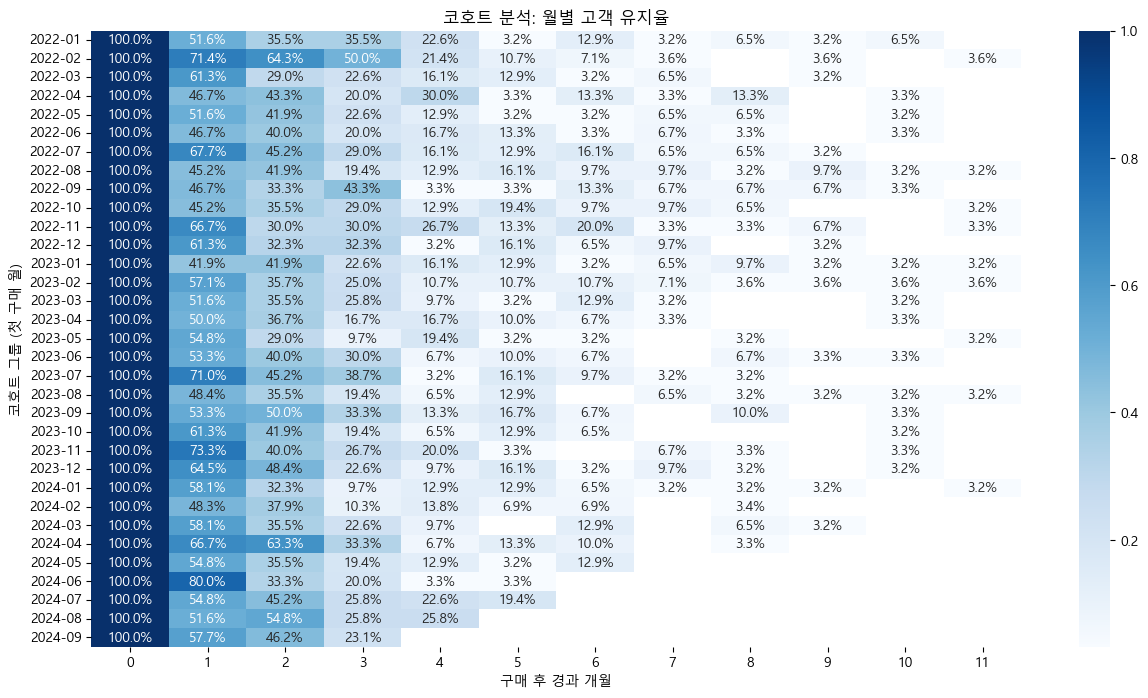


💡 코호트 분석 인사이트
1개월 후 평균 유지율: 56.7%
3개월 후 평균 유지율: 25.3%
6개월 후 평균 유지율: 8.8%


In [13]:
# 첫 구매 월 기준으로 코호트 생성
t_cohort = df.copy()
t_cohort['purchase_period'] = t_cohort['purchase_date'].dt.to_period('M')
# 각 고객의 첫 구매 월
first_purchase = t_cohort.groupby('customer_id')['purchase_date'].min().dt.to_period('M')
first_purchase = first_purchase.reset_index()
first_purchase.columns = ['customer_id', 'cohort_group']

# 코호트 데이터 결합
t_cohort = t_cohort.merge(first_purchase, on='customer_id', how='inner')

# 기간 계산(첫 구매 이후 몇개월 째) -> 이상한 객체가 나왔기 때문에, 처리도 특이한 방법으로 진행
from operator import attrgetter
t_cohort['after_n'] = (t_cohort['purchase_period'] - t_cohort['cohort_group']).apply(attrgetter('n'))


cohort_data = t_cohort.groupby(['cohort_group', 'after_n'])['customer_id'].nunique().reset_index()
cohort_size = first_purchase.groupby('cohort_group')['customer_id'].nunique()

# 각 그룹(최초구매월) 이 N개월이 지났을 때, 총구매회수.
cohort_table = cohort_data.pivot(index='cohort_group', columns='after_n', values='customer_id')

# 각 그룹(최초구매월)별 유지율 계산
cohort_rate = cohort_table.divide(cohort_size, axis=0)


print("📊 코호트 분석 - 고객 유지율")
print("=" * 50)
print("각 셀은 해당 코호트의 고객 유지율을 나타냅니다.")
print(f"예: 첫 구매 후 3개월째 평균 유지율: {cohort_rate[3].mean():.1%}")

# 코호트 히트맵 시각화
plt.figure(figsize=(15, 8))
sns.heatmap(cohort_rate.iloc[:, :12], annot=True, fmt='.1%', cmap='Blues')
plt.title('코호트 분석: 월별 고객 유지율')
plt.xlabel('구매 후 경과 개월')
plt.ylabel('코호트 그룹 (첫 구매 월)')
plt.show()

# 코호트별 인사이트
print("\n💡 코호트 분석 인사이트")
print("=" * 50)
retention_1m = cohort_rate[1].mean()
retention_3m = cohort_rate[3].mean() 
retention_6m = cohort_rate[6].mean() if 6 in cohort_rate.columns else 0

print(f"1개월 후 평균 유지율: {retention_1m:.1%}")
print(f"3개월 후 평균 유지율: {retention_3m:.1%}")
if retention_6m > 0:
    print(f"6개월 후 평균 유지율: {retention_6m:.1%}")

# 유지율 개선 방안 제시
if retention_1m < 0.3:
    print("\n⚠️ 1개월 유지율이 낮습니다. 온보딩 프로세스 개선 필요")
if retention_3m < 0.15:
    print("⚠️ 3개월 유지율이 낮습니다. 고객 참여 프로그램 강화 필요")

In [16]:
df

,customer_id,order_value,purchase_date
0,1,100,2024-01-01
1,1,200,2024-03-01
2,2,150,2024-02-15
3,3,100,2024-01-10
4,3,120,2024-03-15
5,3,110,2024-06-01
6,4,90,2024-04-01
7,5,80,2024-01-01
8,5,85,2024-02-01
9,5,90,2024-03-01


📊 코호트 분석 - 고객 유지율
각 셀은 해당 코호트의 고객 유지율을 나타냅니다.
예: 첫 구매 후 3개월째 평균 유지율: 33.3%


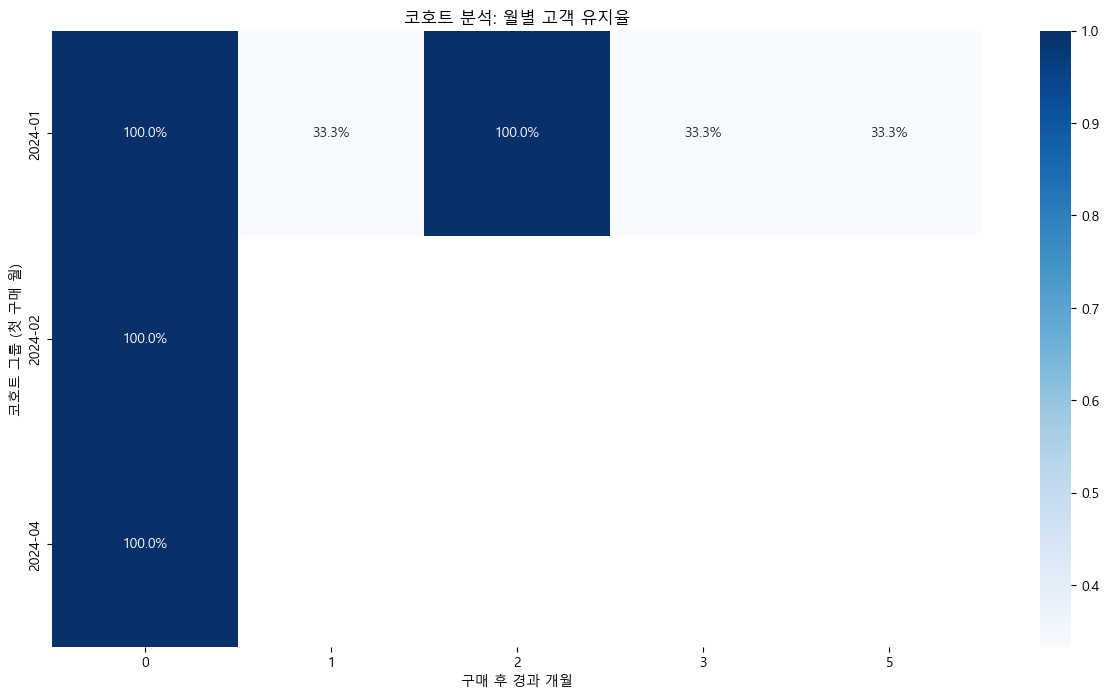


💡 코호트 분석 인사이트
1개월 후 평균 유지율: 33.3%
3개월 후 평균 유지율: 33.3%
최근 12개월 평균 MoM 성장률 -9.3%
최근 12개월 평균 YoY 성장률 nan%


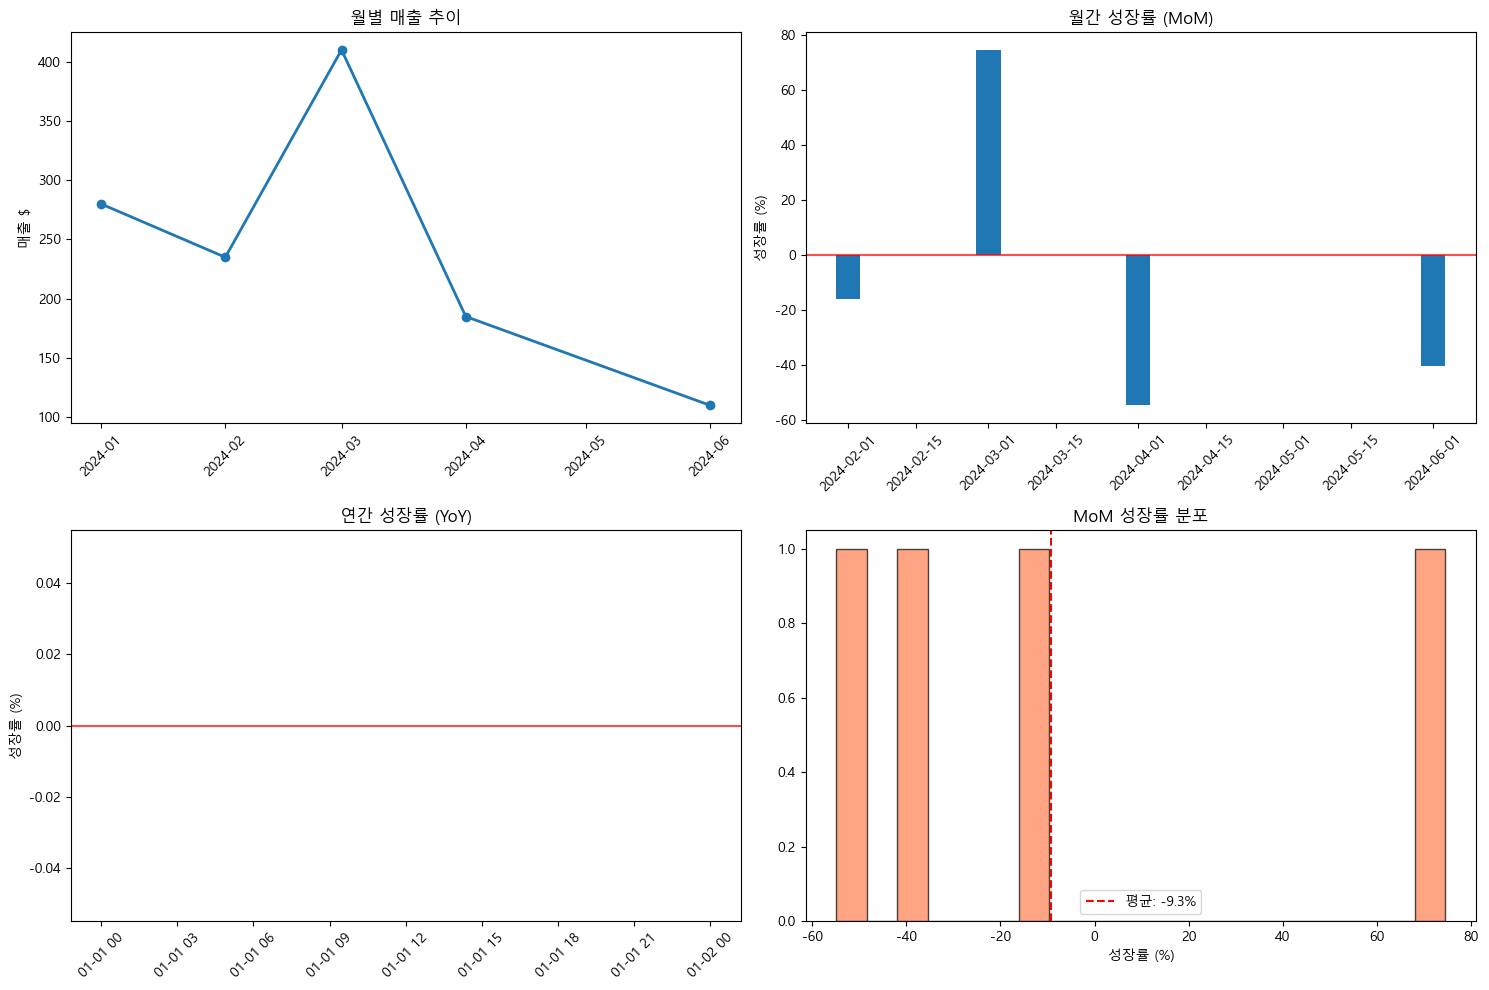

In [17]:
# 첫 구매 월 기준으로 코호트 생성
t_cohort = df.copy()
t_cohort['purchase_period'] = t_cohort['purchase_date'].dt.to_period('M')
# 각 고객의 첫 구매 월
first_purchase = t_cohort.groupby('customer_id')['purchase_date'].min().dt.to_period('M')
first_purchase = first_purchase.reset_index()
first_purchase.columns = ['customer_id', 'cohort_group']

# 코호트 데이터 결합
t_cohort = t_cohort.merge(first_purchase, on='customer_id', how='inner')

# 기간 계산(첫 구매 이후 몇개월 째) -> 이상한 객체가 나왔기 때문에, 처리도 특이한 방법으로 진행
from operator import attrgetter
t_cohort['after_n'] = (t_cohort['purchase_period'] - t_cohort['cohort_group']).apply(attrgetter('n'))


cohort_data = t_cohort.groupby(['cohort_group', 'after_n'])['customer_id'].nunique().reset_index()
cohort_size = first_purchase.groupby('cohort_group')['customer_id'].nunique()

# 각 그룹(최초구매월) 이 N개월이 지났을 때, 총구매회수.
cohort_table = cohort_data.pivot(index='cohort_group', columns='after_n', values='customer_id')

# 각 그룹(최초구매월)별 유지율 계산
cohort_rate = cohort_table.divide(cohort_size, axis=0)
# 실제 분석 및 인사이트
print("📊 코호트 분석 - 고객 유지율")
print("=" * 50)
print("각 셀은 해당 코호트의 고객 유지율을 나타냅니다.")
print(f"예: 첫 구매 후 3개월째 평균 유지율: {cohort_rate[3].mean():.1%}")

# 코호트 히트맵 시각화
plt.figure(figsize=(15, 8))
sns.heatmap(cohort_rate.iloc[:, :12], annot=True, fmt='.1%', cmap='Blues')
plt.title('코호트 분석: 월별 고객 유지율')
plt.xlabel('구매 후 경과 개월')
plt.ylabel('코호트 그룹 (첫 구매 월)')
plt.show()

# 코호트별 인사이트
print("\n💡 코호트 분석 인사이트")
print("=" * 50)
retention_1m = cohort_rate[1].mean()
retention_3m = cohort_rate[3].mean() 
retention_6m = cohort_rate[6].mean() if 6 in cohort_rate.columns else 0

print(f"1개월 후 평균 유지율: {retention_1m:.1%}")
print(f"3개월 후 평균 유지율: {retention_3m:.1%}")
if retention_6m > 0:
    print(f"6개월 후 평균 유지율: {retention_6m:.1%}")

# 유지율 개선 방안 제시
if retention_1m < 0.3:
    print("\n⚠️ 1개월 유지율이 낮습니다. 온보딩 프로세스 개선 필요")
if retention_3m < 0.15:
    print("⚠️ 3개월 유지율이 낮습니다. 고객 참여 프로그램 강화 필요")
# Month Over Month (전월 대비)
# Year Over Year (전년 대비)

"""
월별/연별 성장률 계산 및 트렌드 분석

성장률의 비즈니스적 의미:
- MoM(Month over Month): 단기 성장 모멘텀 파악
- YoY(Year over Year): 계절성을 배제한 장기 성장 트렌드
"""

# MoM 성장률 ('order_value')
# YoY 성장률
# 시각화 까지
# 성장률 진단..?
# 컬럼 추가 안하고 추출 데이터로 그룹핑하기

monthly_revenue = df.groupby(  # 각 월별 주문액 총합
    df['purchase_date'].dt.to_period('M')
)['order_value'].sum().reset_index()

monthly_revenue.columns = ['month', 'revenue']
# month 가 Period 타입이기에, DT로 바꾼다 (일은 강제로 1일)
monthly_revenue['month'] = monthly_revenue['month'].dt.to_timestamp()

# MoM 계산 (전월)
monthly_revenue['revenue_lag1'] = monthly_revenue['revenue'].shift(1)
monthly_revenue['mom_growth'] = (monthly_revenue['revenue'] - monthly_revenue['revenue_lag1']) / monthly_revenue['revenue_lag1'] * 100

# YoY 성장률 (전년 동월)
monthly_revenue['revenue_lag12'] = monthly_revenue['revenue'].shift(12)
monthly_revenue['yoy_growth'] = (monthly_revenue['revenue'] - monthly_revenue['revenue_lag12']) / monthly_revenue['revenue_lag12'] * 100

growth_data = monthly_revenue
# 최근 12개월 성장률 요약

# 전월 대비 성장률 평균
avg_mom = growth_data.tail(12)['mom_growth'].mean()
# 전년 동월 대비 성장률 평균
avg_yoy = growth_data.tail(12)['yoy_growth'].mean()

print(f'최근 12개월 평균 MoM 성장률 {avg_mom:.1f}%')
print(f'최근 12개월 평균 YoY 성장률 {avg_yoy:.1f}%')

# 기존 subplot (x, y, n) 말고 다른 방법
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
a1 = axes[0, 0]
a2 = axes[0, 1]
a3 = axes[1, 0]
a4 = axes[1, 1]

# 데이터가 주어 -> 그래프가 주어(x축, y축)
a1.plot(growth_data['month'], growth_data['revenue'], marker='o', linewidth=2)
a1.set_title('월별 매출 추이')
a1.set_ylabel('매출 $')
a1.tick_params(axis='x', rotation=45)

a2.bar(growth_data['month'], growth_data['mom_growth'], width=5)
a2.axhline(y=0, color='red', linestyle='-', alpha=0.7)
a2.set_title('월간 성장률 (MoM)')
a2.set_ylabel('성장률 (%)')
a2.tick_params(axis='x', rotation=45)

# YoY 성장률
a3.bar(growth_data['month'], growth_data['yoy_growth'], color='lightgreen', width=5)
a3.axhline(y=0, color='red', linestyle='-', alpha=0.7)
a3.set_title('연간 성장률 (YoY)')
a3.set_ylabel('성장률 (%)')
a3.tick_params(axis='x', rotation=45)

# 성장률 분포
growth_rates = growth_data['mom_growth'].dropna()
a4.hist(growth_rates, bins=20, alpha=0.7, color='coral', edgecolor='black')
a4.axvline(x=growth_rates.mean(), color='red', linestyle='--', 
                  label=f'평균: {growth_rates.mean():.1f}%')
a4.set_title('MoM 성장률 분포')
a4.set_xlabel('성장률 (%)')
a4.legend()

plt.tight_layout()
plt.show()

📈 트렌드 분석 결과
최근 7일 트렌드: 하락 (-10.0)
최근 30일 트렌드: 하락 (nan)


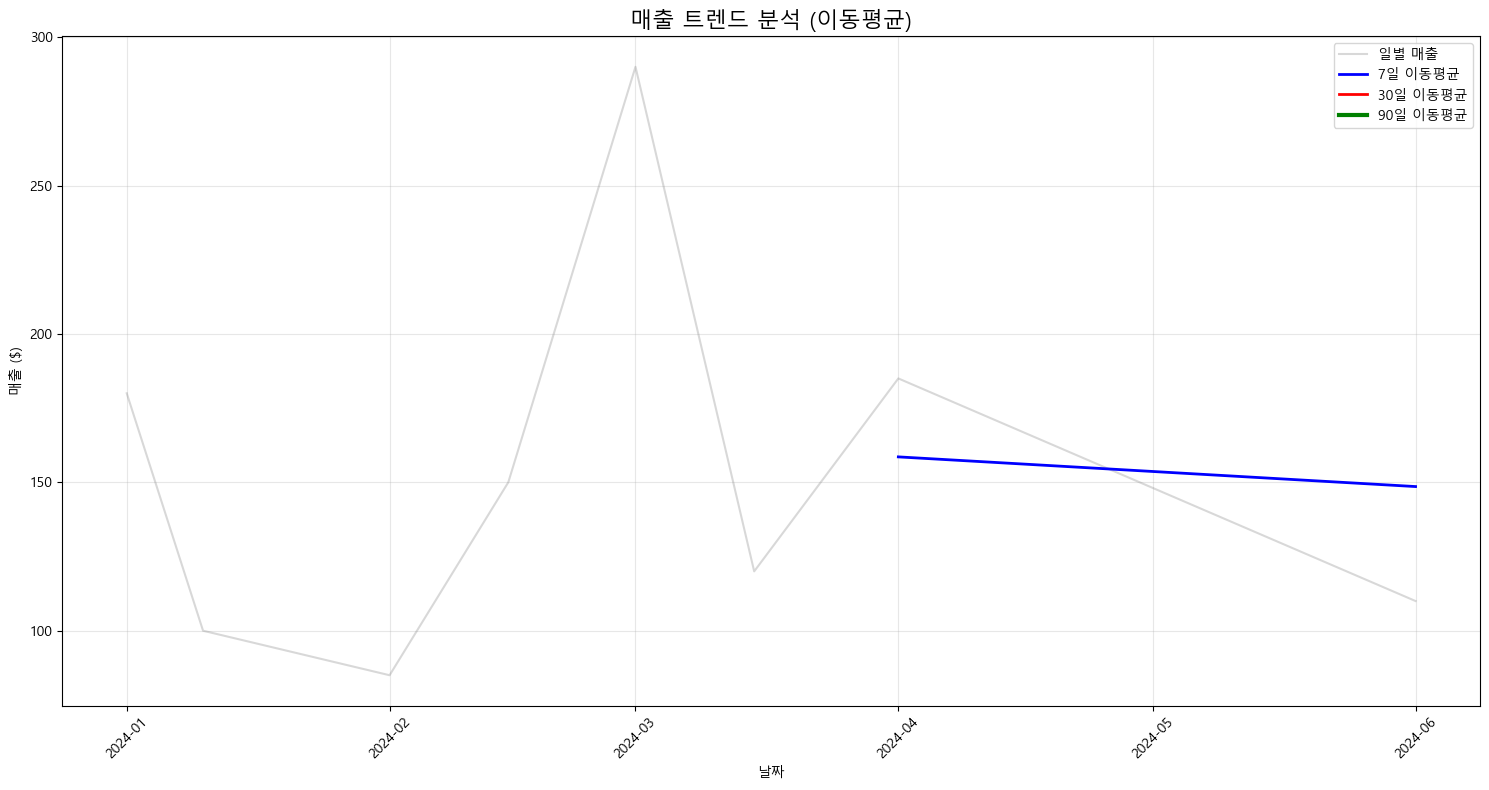

In [18]:
# 트렌드분석

# 일별 매출 집계

# 다양한 기간의 'revenue' 이동평균 (주간, 월간, 분기)

# 트렌드 방향성 분석 + 시각화
def rolling_trend_analysis(transactions_df):
    """
    이동 평균을 활용한 트렌드 분석
    
    이동 평균의 활용:
    - 단기 변동성 제거하여 장기 트렌드 파악
    - 계절성 패턴 식별
    - 이상치의 영향 최소화
    """
    
    # 일별 매출 집계
    daily_revenue = transactions_df.groupby(
        transactions_df['purchase_date'].dt.date
    )['order_value'].sum().reset_index()
    
    daily_revenue.columns = ['date', 'revenue']
    daily_revenue['date'] = pd.to_datetime(daily_revenue['date'])
    daily_revenue = daily_revenue.sort_values('date')
    
    # 다양한 기간의 이동 평균 계산
    daily_revenue['ma_7'] = daily_revenue['revenue'].rolling(window=7).mean()    # 주간
    daily_revenue['ma_30'] = daily_revenue['revenue'].rolling(window=30).mean()  # 월간
    daily_revenue['ma_90'] = daily_revenue['revenue'].rolling(window=90).mean()  # 분기
    
    # 트렌드 방향성 분석
    daily_revenue['trend_7'] = daily_revenue['ma_7'].diff()
    daily_revenue['trend_30'] = daily_revenue['ma_30'].diff()
    
    return daily_revenue

trend_data = rolling_trend_analysis(df)

print("📈 트렌드 분석 결과")
print("=" * 50)

# 최근 트렌드 방향성
recent_trend_7 = trend_data['trend_7'].tail(7).mean()
recent_trend_30 = trend_data['trend_30'].tail(30).mean()

print(f"최근 7일 트렌드: {'상승' if recent_trend_7 > 0 else '하락'} ({recent_trend_7:.1f})")
print(f"최근 30일 트렌드: {'상승' if recent_trend_30 > 0 else '하락'} ({recent_trend_30:.1f})")

# 트렌드 시각화
plt.figure(figsize=(15, 8))

plt.plot(trend_data['date'], trend_data['revenue'], alpha=0.3, color='gray', label='일별 매출')
plt.plot(trend_data['date'], trend_data['ma_7'], color='blue', label='7일 이동평균', linewidth=2)
plt.plot(trend_data['date'], trend_data['ma_30'], color='red', label='30일 이동평균', linewidth=2)
plt.plot(trend_data['date'], trend_data['ma_90'], color='green', label='90일 이동평균', linewidth=3)

plt.title('매출 트렌드 분석 (이동평균)', fontsize=16)
plt.xlabel('날짜')
plt.ylabel('매출 ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd

# 마케팅 지출 및 채널 확장성 점수 (1~100)
marketing_data = pd.DataFrame({
    'channel': ['Google Ads', 'Facebook', 'Instagram', 'Email', 'Organic', 'Referral'],
    'marketing_spend': [50000, 40000, 25000, 10000, 0, 3000],
    'scalability_score': [90, 85, 75, 60, 95, 70]
})

# 고객 획득 수 / LTV / 획득 시간
acquisition_data = pd.DataFrame({
    'channel': ['Google Ads', 'Facebook', 'Instagram', 'Email', 'Organic', 'Referral'],
    'customers_acquired': [200, 180, 120, 80, 300, 60],
    'avg_ltv': [1200, 1000, 800, 700, 950, 1000],
    'avg_acquisition_days': [5, 7, 10, 20, 40, 25]
})

acquisition_data

,channel,customers_acquired,avg_ltv,avg_acquisition_days
0,Google Ads,200,1200,5
1,Facebook,180,1000,7
2,Instagram,120,800,10
3,Email,80,700,20
4,Organic,300,950,40
5,Referral,60,1000,25


In [ ]:
# CAC 계산 (customer Acquistion Cost 

In [1]:
import pandas as pd

# 마케팅 지출 및 채널 확장성 점수 (1~100)
marketing_data = pd.DataFrame({
    'channel': ['Google Ads', 'Facebook', 'Instagram', 'Email', 'Organic', 'Referral'],
    'marketing_spend': [50000, 40000, 25000, 10000, 0, 3000],
    'scalability_score': [90, 85, 75, 60, 95, 70]
})

# 고객 획득 수 / LTV / 획득 시간
acquisition_data = pd.DataFrame({
    'channel': ['Google Ads', 'Facebook', 'Instagram', 'Email', 'Organic', 'Referral'],
    'customers_acquired': [200, 180, 120, 80, 300, 60],
    'avg_ltv': [1200, 1000, 800, 700, 950, 1000],
    'avg_acquisition_days': [5, 7, 10, 20, 40, 25]
})

acquisition_data

,channel,customers_acquired,avg_ltv,avg_acquisition_days
0,Google Ads,200,1200,5
1,Facebook,180,1000,7
2,Instagram,120,800,10
3,Email,80,700,20
4,Organic,300,950,40
5,Referral,60,1000,25


In [2]:
# CAC 계산 (Customer Acquisition Cost - 고객 획득 비용)

perf_df = pd.merge(marketing_data, acquisition_data, on='channel')

# 1. 'avg_ltv' 고객 퀄리티 가중치 
perf_df['quality_weight'] = perf_df['avg_ltv'] / perf_df['avg_ltv'].mean()

# 2. 'avg_acq_days'시간가치 가중치 (획득 속도)
perf_df['time_weight'] = perf_df['avg_acquisition_days'].max() / perf_df['avg_acquisition_days']

# 3. 'scalability' 확장성 가중치
perf_df['scalability_weight'] = perf_df['scalability_score'] / 100

# 종합 가중치 (qw - 50%, tw-30%, sw-20%)
perf_df['composite_weight'] = (
    perf_df['quality_weight'] * 0.5 + 
    perf_df['time_weight'] * 0.3 +
    perf_df['scalability_weight'] * 0.2
)

# 일반 CAC 계산 -> 각 채널별 1인 데려오는데 쓴돈
perf_df['simple_cac'] = perf_df['marketing_spend'] / perf_df['customers_acquired']

# 가중치 반영한 CAC 계산
perf_df['weighted_cac'] = perf_df['simple_cac'] / perf_df['composite_weight']

perf_df

,channel,marketing_spend,scalability_score,customers_acquired,avg_ltv,avg_acquisition_days,quality_weight,time_weight,scalability_weight,composite_weight,simple_cac,weighted_cac
0,Google Ads,50000,90,200,1200,5,1.274336,8.000000,0.90,3.217168,250.000000,77.708093
1,Facebook,40000,85,180,1000,7,1.061947,5.714286,0.85,2.415259,222.222222,92.007610
2,Instagram,25000,75,120,800,10,0.849558,4.000000,0.75,1.774779,208.333333,117.385523
3,Email,10000,60,80,700,20,0.743363,2.000000,0.60,1.091681,125.000000,114.502270
4,Organic,0,95,300,950,40,1.008850,1.000000,0.95,0.994425,0.000000,0.000000
5,Referral,3000,70,60,1000,25,1.061947,1.600000,0.70,1.150973,50.000000,43.441489


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16608\2883436930.py:73: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16608\2883436930.py:73: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16608\2883436930.py:73: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16608\2883436930.py:73: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16608\2883436930.py:73: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16608\2883436930

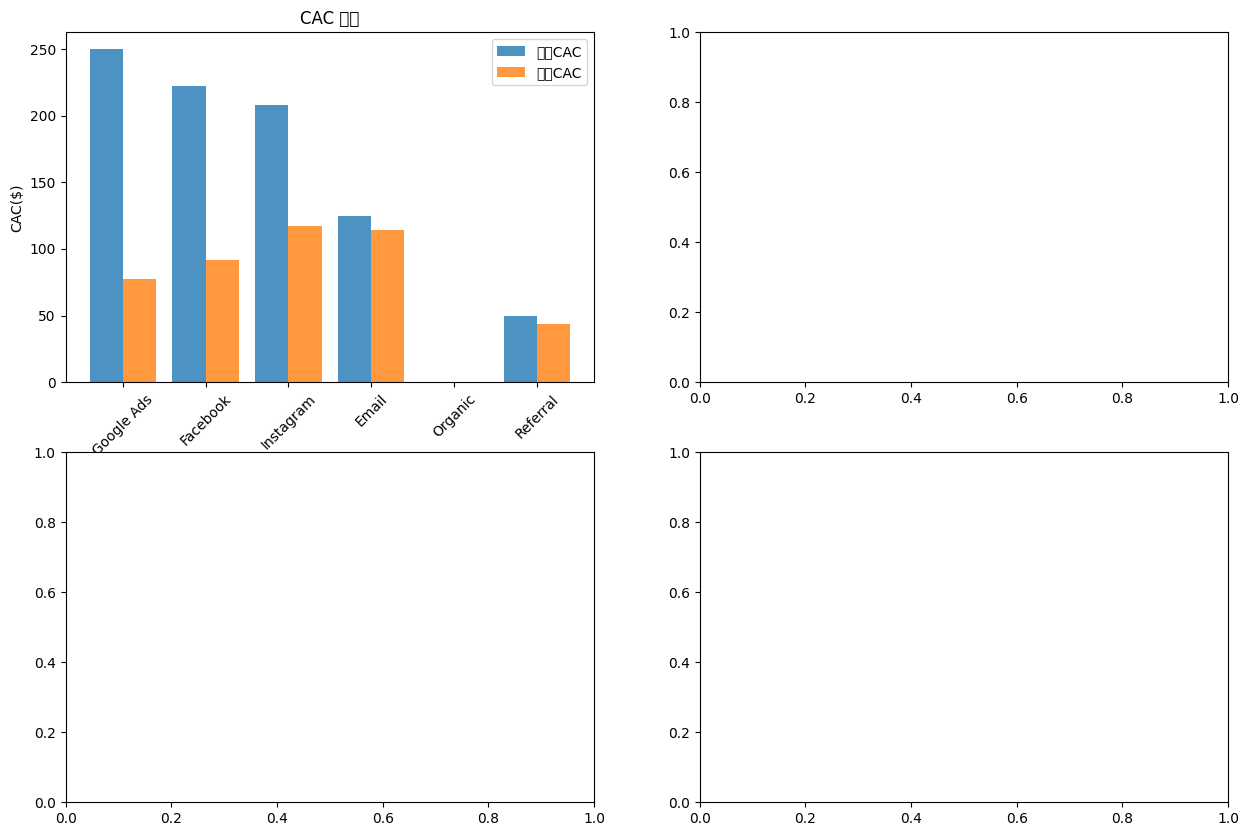

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45328 (\N{HANGUL SYLLABLE NEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\IP

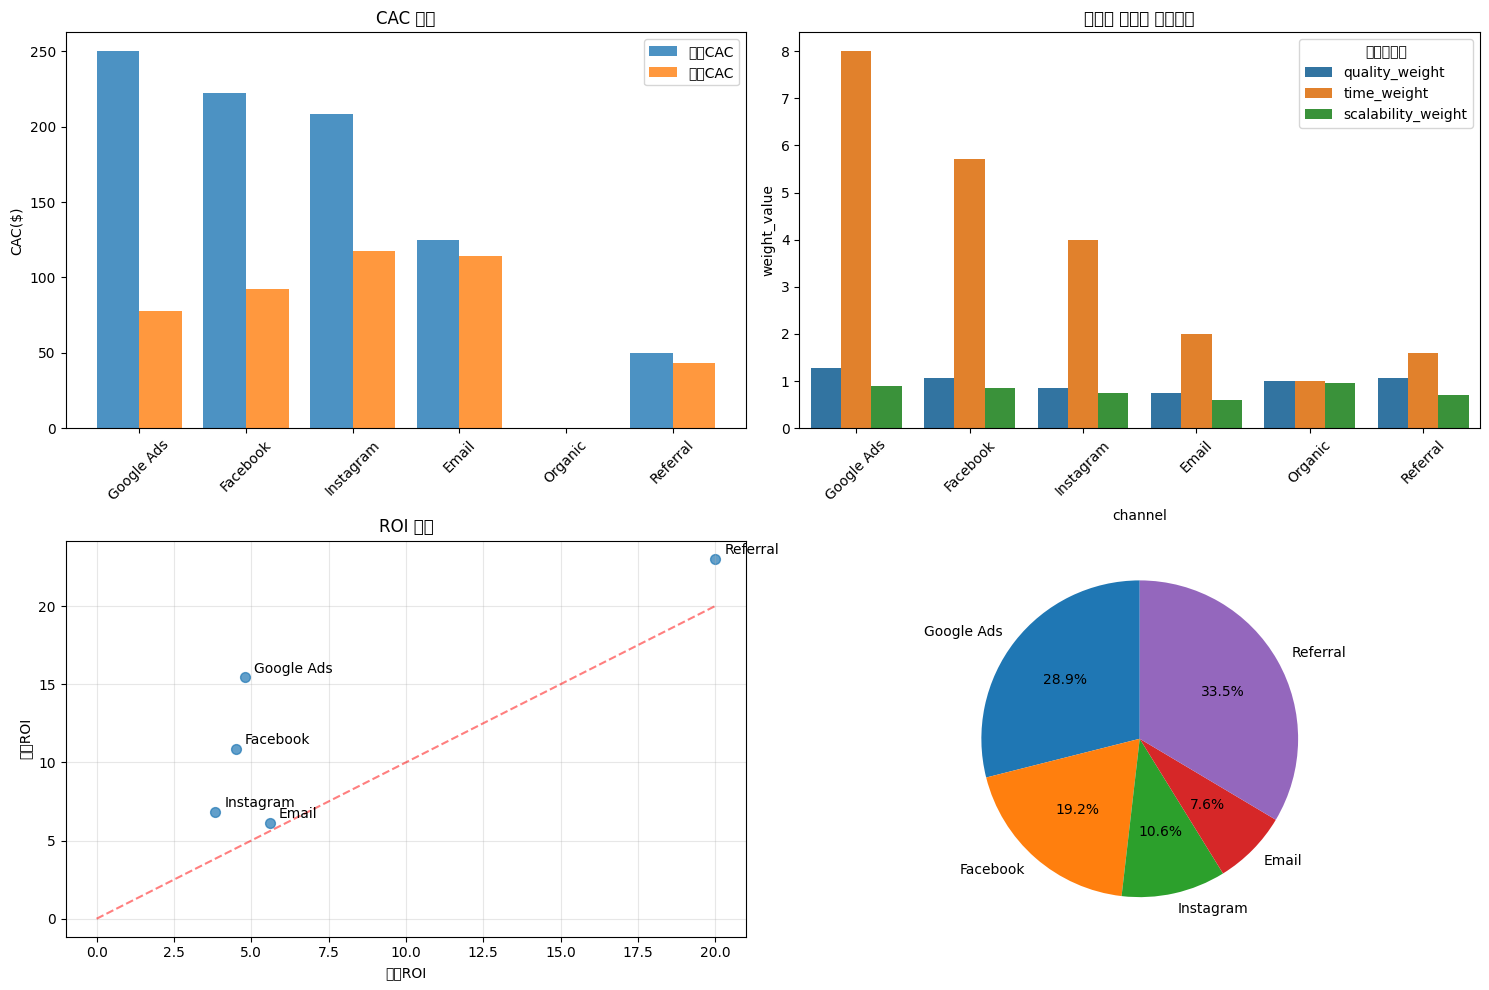

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
x_pos = np.arange(len(perf_df))
a1, a2, a3, a4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

# 단순 CAC, 가중 CAC 비교
a1.bar(x_pos-0.2, perf_df['simple_cac'], 0.4, label='단순CAC', alpha=0.8)
a1.bar(x_pos+0.2, perf_df['weighted_cac'], 0.4, label='가중CAC', alpha=0.8)
a1.set_title('CAC 비교')
a1.set_xticks(x_pos)
a1.set_xticklabels(perf_df['channel'], rotation=45)
a1.set_ylabel('CAC($)')
a1.legend()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
x_pos = np.arange(len(perf_df))
a1, a2, a3, a4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

# 단순 CAC, 가중 CAC 비교
a1.bar(x_pos-0.2, perf_df['simple_cac'], 0.4, label='단순CAC', alpha=0.8)
a1.bar(x_pos+0.2, perf_df['weighted_cac'], 0.4, label='가중CAC', alpha=0.8)
a1.set_title('CAC 비교')
a1.set_xticks(x_pos)
a1.set_xticklabels(perf_df['channel'], rotation=45)
a1.set_ylabel('CAC($)')
a1.legend()

# 가중치 구성요소 분석
weight_comp = perf_df[['channel', 'quality_weight', 'time_weight', 'scalability_weight']]
# pivot <-> melt
weight_melted = weight_comp.melt(id_vars=['channel'], var_name='weight_type', value_name='weight_value')
import seaborn as sns
sns.barplot(data=weight_melted, x='channel', y='weight_value', hue='weight_type', ax=a2)
a2.tick_params(axis='x', rotation=45)
a2.set_title('채널별 가중치 구성요소')
a2.legend(title='가중치유형')


# ROI 분석 (LTV/CAC 비율)
perf_df['simple_roi'] = perf_df['avg_ltv'] / perf_df['simple_cac']
perf_df['weighted_roi'] = perf_df['avg_ltv'] / perf_df['weighted_cac']
# 산점도
a3.scatter(perf_df['simple_roi'], perf_df['weighted_roi'], s=50, alpha=0.7)
# 각 점마다 채널명 표시하기
for idx, channel in enumerate(perf_df['channel']):
    a3.annotate(channel, (perf_df['simple_roi'].iloc[idx]+0.3, perf_df['weighted_roi'].iloc[idx]+0.3))

# 대각선 그리기 -> 선 위의 점들은 과소평가된 채널들 / 선 아래 점들은 점검해볼 채널
a3.plot([0, 20], [0, 20], 'r--', alpha=0.5)

a3.set_title('ROI 비교')
a3.set_xlabel('단순ROI')
a3.set_ylabel('가중ROI')
a3.grid(True, alpha=0.3)

# 최적 마케팅 믹스 제안 (파이 그래프)
"""
ROI 와 Scalability 를 함께 고려할 예정
1. 효율성 지표(Efficiency Score) 라는 항목으로 ROI, 확장성을 동시에 계산 -> 성과도 좋고 확장 여지도 크다
2. 예산 배분 기준 -> 효율성 지표에 따라
"""
budget_opt = perf_df.copy()
# Organic 행 삭제
budget_opt.drop(4, axis=0, inplace=True)
# 숫자가 너무 커서 나눔
budget_opt['eff_score'] = budget_opt['weighted_roi'] * budget_opt['scalability_score'] / 100
budget_opt['recommend_pct'] = budget_opt['eff_score'] / budget_opt['eff_score'].sum() * 100

a4.pie(budget_opt['recommend_pct'], labels=budget_opt['channel'], autopct='%1.1f%%', startangle=90)

plt.tight_layout()
plt.show()